# THESIS CODE NOTEBOOK

## PIP INSTALLS


In [1]:
'''pip install imblearn
pip install pandas pyreadstat
pip install factor-analyzer
pip install tensorflow
pip install matplotlib
pip install seaborn'''

## IMPORT LIBRARIES

In [29]:
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

## IMPORT AND MERGING OF NHANES DATA FILES

In [3]:
# Function to incrementally merge .xpt files
def merge_xpt_files_incrementally(file_paths):
    cumulative_df = pd.DataFrame()  # Initialize an empty DataFrame
    for file_path in file_paths:
        # Read each .xpt file into a DataFrame
        df, meta = pyreadstat.read_xport(file_path)
        
        # If the cumulative DataFrame is empty, simply assign the first DataFrame to it
        if cumulative_df.empty:
            cumulative_df = df
        else:
            # Merge the current DataFrame with the cumulative DataFrame
            cumulative_df = pd.merge(cumulative_df, df, on='SEQN', how='outer')
    
    return cumulative_df




file_paths = ['P_ALQ (1).XPT', 'P_DBQ (1).XPT', 'P_DPQ (5).XPT', 'P_INQ.XPT', 
              'P_OCQ.XPT', 'P_PAQ (2).XPT', 'P_SLQ (2).XPT', 'P_SMQ.XPT', 'P_SMQRTU.XPT', 'P_SMQSHS.XPT', 'P_WHQ.XPT']  # Add your file paths here
merged_df = merge_xpt_files_incrementally(file_paths)

# FILE NAMES:
'''   'P_ALQ (1).XPT' = 'Alcohol use', 'P_DBQ (1).XPT' = 'Diet behaviour and nutrition', 'P_DPQ (5).XPT' = 'Mental health - depression screener'
, 'P_INQ.XPT' = ' Income', 'P_OCQ.XPT' = 'Occupation', 'P_PAQ (2).XPT' = 'Physical activity'
, 'P_SLQ (2).XPT' = 'Sleep disorders', 'P_SMQ.XPT' = 'Smoking - cigarette use', 'P_SMQRTU.XPT' = 'Smoking - recent tobacco use'
, 'P_SMQSHS.XPT' = 'Smoking - Secondhand smoke exposure', 'P_WHQ.XPT' = 'Weight history'   '''

# Now `merged_df` contains the merged data from all files based on 'SEQN'


"   'P_ALQ (1).XPT' = 'Alcohol use', 'P_DBQ (1).XPT' = 'Diet behaviour and nutrition', 'P_DPQ (5).XPT' = 'Mental health - depression screener'\n, 'P_INQ.XPT' = ' Income', 'P_OCQ.XPT' = 'Occupation', 'P_PAQ (2).XPT' = 'Physical activity'\n, 'P_SLQ (2).XPT' = 'Sleep disorders', 'P_SMQ.XPT' = 'Smoking - cigarette use', 'P_SMQRTU.XPT' = 'Smoking - recent tobacco use'\n, 'P_SMQSHS.XPT' = 'Smoking - Secondhand smoke exposure', 'P_WHQ.XPT' = 'Weight history'   "

## EDA

In [4]:
merged_df

,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ270,ALQ280,ALQ290,ALQ151,ALQ170,...,WHD080S,WHD080T,WHD080U,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150
0,109263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,109265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,109266.0,1.0,10.0,1.0,0.0,NaN,NaN,NaN,2.0,0.0,...,NaN,46.0,NaN,NaN,2.0,NaN,210.0,NaN,218.0,28.0
4,109267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,148.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,124818.0,1.0,9.0,2.0,0.0,NaN,NaN,NaN,2.0,0.0,...,NaN,NaN,NaN,NaN,3.0,190.0,180.0,NaN,235.0,40.0
15556,124819.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15557,124820.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15558,124821.0,1.0,5.0,5.0,7.0,0.0,0.0,NaN,2.0,0.0,...,NaN,NaN,NaN,NaN,5.0,170.0,165.0,71.0,183.0,55.0


In [5]:
unique_count = merged_df['SEQN'].nunique()

print(f"The number of unique values in 'SEQN' is: {unique_count}")

The number of unique values in 'SEQN' is: 15560


In [6]:
merged_df.describe()

,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ270,ALQ280,ALQ290,ALQ151,ALQ170,...,WHD080S,WHD080T,WHD080U,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150
count,15560.00000,8370.000000,7503.000000,5863.000000,5863.000000,2471.000000,2471.000000,933.000000,7501.000000,5849.000000,...,2158.0,2309.0,27.0,79.0,10195.000000,6988.000000,8283.000000,4956.000000,9692.000000,9545.000000
mean,117042.50000,1.103584,4.945622,4.187958,3.390585,4.541076,3.290571,4.372990,1.859085,14.965122,...,45.0,46.0,35.0,40.0,3.343698,481.711505,618.243390,437.880549,344.200887,787.766894
std,4491.92943,0.304739,3.976266,40.354534,6.646142,11.287727,7.357537,10.020697,0.438490,111.289489,...,0.0,0.0,0.0,0.0,1.810301,1694.794890,2080.666173,1881.916616,1171.931097,8577.765602
min,109263.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,45.0,46.0,35.0,40.0,1.000000,72.000000,55.000000,41.000000,85.000000,10.000000
25%,113152.75000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,45.0,46.0,35.0,40.0,1.000000,145.000000,126.000000,64.000000,160.000000,27.000000
50%,117042.50000,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,45.0,46.0,35.0,40.0,4.000000,170.000000,150.000000,66.000000,190.000000,39.000000
75%,120932.25000,1.000000,8.000000,3.000000,7.000000,8.000000,7.000000,8.000000,2.000000,1.000000,...,45.0,46.0,35.0,40.0,5.000000,205.250000,180.000000,70.000000,234.000000,54.000000
max,124822.00000,2.000000,99.000000,999.000000,99.000000,99.000000,99.000000,99.000000,9.000000,999.000000,...,45.0,46.0,35.0,40.0,9.000000,9999.000000,9999.000000,9999.000000,9999.000000,99999.000000


## DATA PREPROCESSING 

In [7]:
# Specifie the phq-9 features 
phq_columns = [
    'DPQ060', 'DPQ090', 'DPQ040', 'DPQ080',
    'DPQ010', 'DPQ030', 'DPQ020', 'DPQ070',
    'DPQ050'
]

# Drop rows where any of the specified columns have missing values
merged_df = merged_df.dropna(subset=phq_columns)

In [8]:
# REPLACE REFUSE AND DONT KNOW ANSWERS WITH NAN VALUES


def replace_special_codes(df):
    # Define the sets of codes in the order they should be checked
    codes_sets = [
        (777777, 999999),
        (77777, 99999),
        (7777, 9999),
        (7777, 9999),
        (777, 999),  # Highest priority codes
        (77, 99),    # Next priority
        (7, 9)       # Lowest priority
    ]
    
    # Iterate through each column in the DataFrame
    for column in df.columns:
        # Check for each set of codes until a match is found
        for codes in codes_sets:
            if any(df[column].isin(codes)):
                # Replace codes with NaN
                df[column] = df[column].replace(list(codes), np.nan)
                # Move to the next column after handling one set of codes
                break  # Break the inner loop to skip to the next column

    return df

# Example usage with a DataFrame 'df'
df = pd.DataFrame({
    'A': [777, 999, 99, 9, 77, 7],
    'B': [7, 9, 77, 2, 99, 4],
    'C': [1, 2, 3, 7, 9, 6],
    'D': [1, 2, 3, 4, 5, 6]  # No special codes
 })

# Apply the function
df = replace_special_codes(df)

# Check the result
print(df)


# Aply to our dataframe
merged_df = replace_special_codes(merged_df)

      A    B    C  D
0   NaN  7.0  1.0  1
1   NaN  9.0  2.0  2
2  99.0  NaN  3.0  3
3   9.0  2.0  NaN  4
4  77.0  NaN  NaN  5
5   7.0  4.0  6.0  6


C:\Users\giann\AppData\Local\Temp\ipykernel_16352\998556999.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].replace(list(codes), np.nan)


In [9]:
# REMOVE NUMERICAL FEATURES FROM THE DATAFRAME

# List of columns you want to drop
columns_to_drop = ['ALQ130', 'ALQ170', 'DBD030', 'DBD050', 'SLQ300', 'SLQ310', 'SLQ320', 'SLQ330']

# Drop the columns from the DataFrame
merged_df = merged_df.drop(columns=columns_to_drop)

In [10]:
# Calculate the percentage of missing values for each column
missing_percentages = merged_df.isnull().mean() * 100

# Display the percentages in a more readable format
print("Percentage of missing values per column:")
with pd.option_context('display.max_rows', None):
    print(missing_percentages.sort_values(ascending=False))

Percentage of missing values per column:
DBQ073E      100.000000
DBD041       100.000000
SMQ690G      100.000000
DBQ073U      100.000000
DBQ073D      100.000000
DBQ073C      100.000000
DBQ073B      100.000000
DBQ073A      100.000000
DBD061       100.000000
DBD055       100.000000
DBQ010       100.000000
SMD630       100.000000
SMQ621       100.000000
SMQ740        99.843411
SMQ690B       99.843411
WHD080U       99.698868
SMQ690K       99.686822
SMQ845        99.578415
SMQ690F       99.554324
SMQ830        99.554324
DBQ421        99.457962
WHD080P       99.433871
WHD080L       99.325464
SMQ817        99.289328
SMQ690E       99.289328
DBQ424        99.241147
SMQ690D       99.229101
SMQ800        99.229101
WHD080K       99.144784
DBQ390        99.096603
DBD411        98.855697
DBQ400        98.783426
DBD381        98.783426
DBQ370        98.771380
WHD080I       98.494339
WHD080H       97.892074
DBQ223E       97.819802
SMQ849        97.325946
SMQ690H       97.325946
WHD080J       97.121176

In [11]:
merged_df.describe()

,SEQN,ALQ111,ALQ121,ALQ142,ALQ270,ALQ280,ALQ290,ALQ151,DBQ010,DBD041,...,WHD080S,WHD080T,WHD080U,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150
count,8302.000000,8298.000000,7452.000000,5829.000000,2438.000000,2458.000000,923.000000,7445.000000,0.0,0.0,...,1854.0,1957.0,25.0,56.0,8270.000000,5814.000000,6816.000000,4079.000000,8210.000000,8157.000000
mean,117137.526259,1.101470,4.918814,3.093155,3.361772,2.878763,3.468039,1.849832,NaN,NaN,...,45.0,46.0,35.0,40.0,3.258767,178.472136,156.134683,66.512135,202.152741,40.718524
std,4497.288265,0.301969,3.466965,3.973454,4.152653,4.031211,4.151393,0.357260,NaN,NaN,...,0.0,0.0,0.0,0.0,1.765152,49.421016,42.016917,4.291807,58.101629,16.875085
min,109266.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,...,45.0,46.0,35.0,40.0,1.000000,72.000000,60.000000,41.000000,90.000000,10.000000
25%,113246.750000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,NaN,NaN,...,45.0,46.0,35.0,40.0,1.000000,145.000000,125.000000,64.000000,160.000000,26.000000
50%,117133.500000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,NaN,NaN,...,45.0,46.0,35.0,40.0,4.000000,170.000000,150.000000,66.000000,190.000000,39.000000
75%,121064.750000,1.000000,8.000000,7.000000,7.000000,7.000000,8.000000,2.000000,NaN,NaN,...,45.0,46.0,35.0,40.0,5.000000,200.000000,179.000000,70.000000,230.000000,54.000000
max,124822.000000,2.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,NaN,NaN,...,45.0,46.0,35.0,40.0,5.000000,700.000000,530.000000,89.000000,700.000000,80.000000


### visualization for missing values

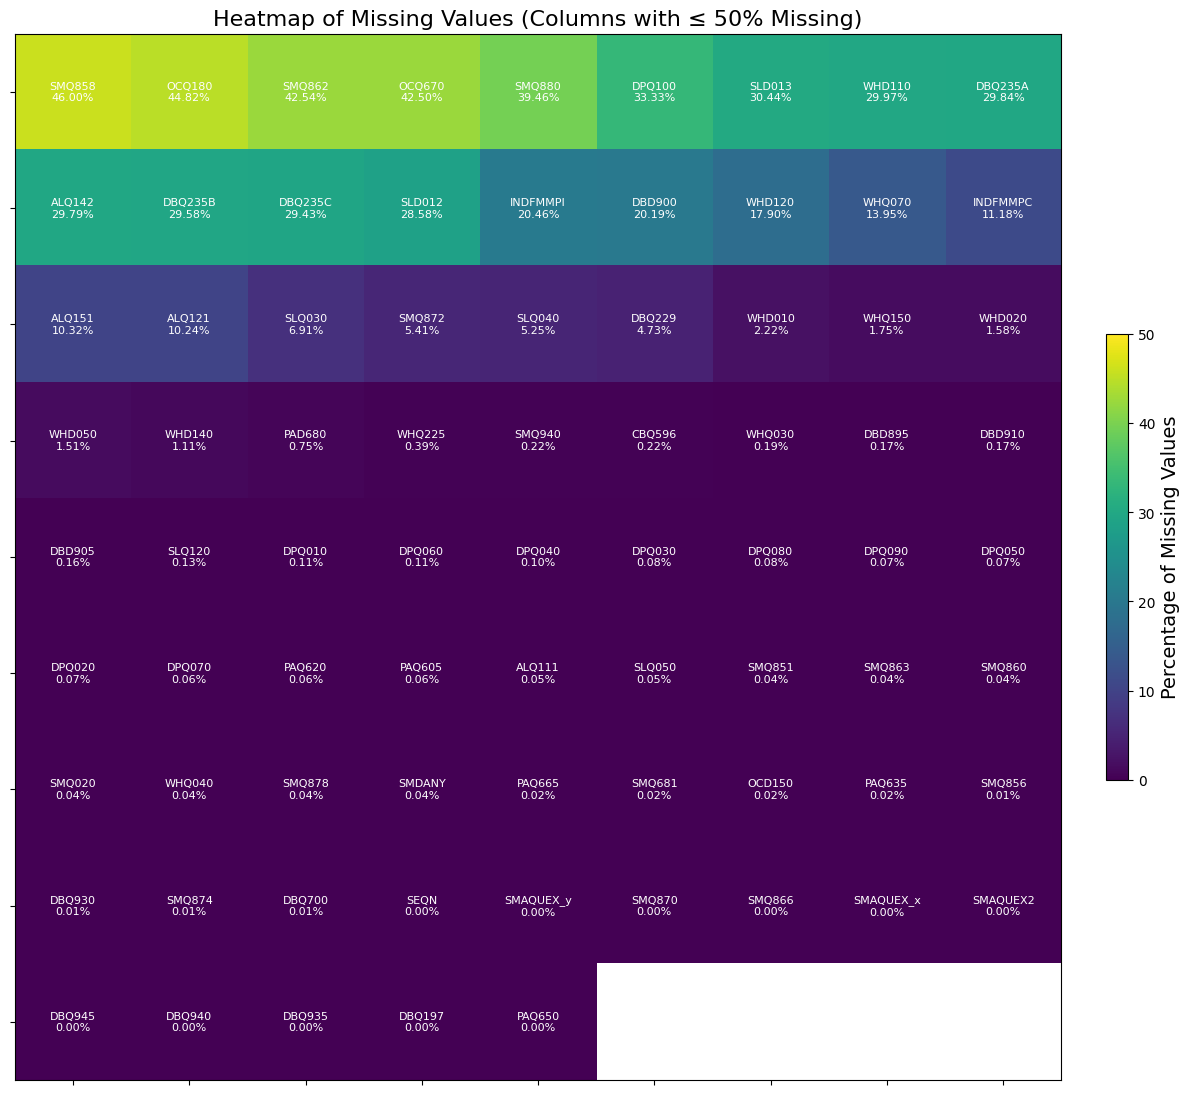

In [12]:
# Filter out columns with 50% or less missing values, including columns with 0% missing
filtered_missing_percentages = missing_percentages[missing_percentages <= 50]

# Sort the missing percentages in descending order for better visualization
missing_percentages_sorted = filtered_missing_percentages.sort_values(ascending=False)

# Check if there are columns to plot
if not missing_percentages_sorted.empty:
    # Determine the number of rows and columns for the grid
    num_columns = len(missing_percentages_sorted)
    grid_size = int(math.ceil(math.sqrt(num_columns)))
    
    # Create a 2D array of missing percentages with padding for the grid
    data = np.full((grid_size, grid_size), np.nan)
    data.flat[:num_columns] = missing_percentages_sorted.values

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 12))
    cax = ax.imshow(data, cmap='viridis', aspect='equal', norm=mcolors.Normalize(vmin=0, vmax=50))

    # Add color bar
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Percentage of Missing Values', fontsize=14)

    # Set axis labels
    ax.set_title('Heatmap of Missing Values (Columns with ≤ 50% Missing)', fontsize=16)
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))

    # Set the labels for the squares
    labels = np.array(missing_percentages_sorted.index.tolist() + [''] * (grid_size**2 - num_columns))
    labels = labels.reshape((grid_size, grid_size))
    
    # Set the tick labels
    ax.set_xticklabels([''] * grid_size)
    ax.set_yticklabels([''] * grid_size)
    
    # Annotate each square with the column name and the percentage value
    for i in range(grid_size):
        for j in range(grid_size):
            if not np.isnan(data[i, j]):
                ax.text(j, i, f'{labels[i, j][:10]}\n{data[i, j]:.2f}%', ha='center', va='center', color='white', fontsize=8)

    # Adjust layout and save the plot as an image
    plt.tight_layout()
    plt.savefig('missing_values_heatmap_grid.png')
    plt.show()
else:
    print("No columns with missing values less than or equal to 50%")


In [13]:
# Filter columns that have less than 50% missing values
columns_to_keep = missing_percentages[missing_percentages < 50].index

# Update the DataFrame to only include these columns
merged_df = merged_df[columns_to_keep]
merged_df

,SEQN,ALQ111,ALQ121,ALQ142,ALQ151,DBQ700,DBQ197,DBQ229,DBQ235A,DBQ235B,...,WHD020,WHQ030,WHQ040,WHD050,WHQ070,WHQ225,WHD110,WHD120,WHD140,WHQ150
3,109266.0,1.0,10.0,0.0,2.0,3.0,2.0,3.0,3.0,3.0,...,210.0,1.0,2.0,200.0,1.0,2.0,NaN,210.0,218.0,28.0
8,109271.0,1.0,0.0,NaN,1.0,3.0,1.0,2.0,NaN,NaN,...,222.0,3.0,3.0,180.0,2.0,4.0,280.0,350.0,350.0,24.0
10,109273.0,1.0,0.0,NaN,2.0,4.0,1.0,2.0,NaN,NaN,...,165.0,2.0,1.0,155.0,2.0,2.0,150.0,155.0,300.0,16.0
11,109274.0,1.0,4.0,5.0,2.0,2.0,1.0,3.0,3.0,3.0,...,219.0,1.0,2.0,230.0,NaN,1.0,240.0,190.0,270.0,54.0
19,109282.0,1.0,0.0,NaN,2.0,4.0,1.0,3.0,3.0,2.0,...,185.0,1.0,2.0,175.0,2.0,5.0,175.0,135.0,208.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15552,124815.0,1.0,3.0,0.0,2.0,3.0,0.0,2.0,NaN,NaN,...,217.0,3.0,3.0,210.0,2.0,5.0,185.0,160.0,220.0,50.0
15554,124817.0,1.0,3.0,0.0,2.0,4.0,1.0,3.0,1.0,0.0,...,175.0,1.0,2.0,150.0,1.0,1.0,150.0,130.0,175.0,67.0
15555,124818.0,1.0,9.0,0.0,2.0,4.0,1.0,2.0,NaN,NaN,...,235.0,1.0,2.0,235.0,1.0,3.0,190.0,180.0,235.0,40.0
15558,124821.0,1.0,5.0,7.0,2.0,2.0,1.0,3.0,3.0,3.0,...,180.0,3.0,3.0,170.0,2.0,5.0,170.0,165.0,183.0,55.0


## FEATURE ENGINEERING

In [14]:
# List of PHQ-9 column names
phq_columns = [
    'DPQ060', 'DPQ090', 'DPQ040', 'DPQ080',
    'DPQ010', 'DPQ030', 'DPQ020', 'DPQ070',
    'DPQ050'
]

# Calculate the PHQ-9 total score by summing the scores across the PHQ-9 columns
merged_df['PHQ9_total'] = merged_df[phq_columns].sum(axis=1)

# Create a new column 'depressed' where 1 indicates a PHQ-9 score of 10 or more, and 0 otherwise
merged_df['Depressed'] = (merged_df['PHQ9_total'] >= 10).astype(int)


# List of columns to drop
columns_to_drop = [
    'DPQ060', 'DPQ090', 'DPQ040', 'DPQ080',
    'DPQ010', 'DPQ030', 'DPQ020', 'DPQ070',
    'DPQ050', 'DPQ100'
]


# To modify the original DataFrame directly (without creating a new variable), you can use the inplace parameter
merged_df.drop(columns=columns_to_drop, inplace=True)


# Now the DataFrame 'merged_df' has a new column 'Depressed' which is the ground truth for depression
merged_df

,SEQN,ALQ111,ALQ121,ALQ142,ALQ151,DBQ700,DBQ197,DBQ229,DBQ235A,DBQ235B,...,WHQ040,WHD050,WHQ070,WHQ225,WHD110,WHD120,WHD140,WHQ150,PHQ9_total,Depressed
3,109266.0,1.0,10.0,0.0,2.0,3.0,2.0,3.0,3.0,3.0,...,2.0,200.0,1.0,2.0,NaN,210.0,218.0,28.0,0.0,0
8,109271.0,1.0,0.0,NaN,1.0,3.0,1.0,2.0,NaN,NaN,...,3.0,180.0,2.0,4.0,280.0,350.0,350.0,24.0,5.0,0
10,109273.0,1.0,0.0,NaN,2.0,4.0,1.0,2.0,NaN,NaN,...,1.0,155.0,2.0,2.0,150.0,155.0,300.0,16.0,15.0,1
11,109274.0,1.0,4.0,5.0,2.0,2.0,1.0,3.0,3.0,3.0,...,2.0,230.0,NaN,1.0,240.0,190.0,270.0,54.0,0.0,0
19,109282.0,1.0,0.0,NaN,2.0,4.0,1.0,3.0,3.0,2.0,...,2.0,175.0,2.0,5.0,175.0,135.0,208.0,33.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15552,124815.0,1.0,3.0,0.0,2.0,3.0,0.0,2.0,NaN,NaN,...,3.0,210.0,2.0,5.0,185.0,160.0,220.0,50.0,0.0,0
15554,124817.0,1.0,3.0,0.0,2.0,4.0,1.0,3.0,1.0,0.0,...,2.0,150.0,1.0,1.0,150.0,130.0,175.0,67.0,4.0,0
15555,124818.0,1.0,9.0,0.0,2.0,4.0,1.0,2.0,NaN,NaN,...,2.0,235.0,1.0,3.0,190.0,180.0,235.0,40.0,1.0,0
15558,124821.0,1.0,5.0,7.0,2.0,2.0,1.0,3.0,3.0,3.0,...,3.0,170.0,2.0,5.0,170.0,165.0,183.0,55.0,5.0,0


## EDA 2

In [15]:
unique_count = merged_df['Depressed'].value_counts()

print(f"The number of unique values in 'Depressed' is: {unique_count}")

The number of unique values in 'Depressed' is: Depressed
0    7532
1     770
Name: count, dtype: int64


In [16]:
depressed_percentage = merged_df['Depressed'].value_counts(normalize=True)

print("Percentage counts for the column 'Depressed':")
print(depressed_percentage * 100) 

Percentage counts for the column 'Depressed':
Depressed
0    90.725126
1     9.274874
Name: proportion, dtype: float64


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_df' is your DataFrame
depressed_percentage = merged_df['Depressed'].value_counts(normalize=True) * 100

# Set up the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(depressed_percentage.index, depressed_percentage, color=['skyblue', 'salmon'], edgecolor='black')

# Add percentage annotations on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 5, f'{height:.2f}%', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Customize the plot
plt.xlabel('Class', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Percentage of Depressed vs Non-Depressed', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Non-Depressed', 'Depressed'], rotation=0, fontsize=12)
plt.ylim(0, 100)  # Ensure the y-axis goes from 0 to 100

# Save the plot as an image file
plt.tight_layout()
plt.savefig('depressed_percentage_plot.png')
plt.close()

# Display the plot
plt.show()


In [18]:
# Calculate the percentage of missing values for each column
missing_percentages = merged_df.isnull().mean() * 100

# Display the percentages in a more readable format
print("Percentage of missing values per column:")
with pd.option_context('display.max_rows', None):
    print(missing_percentages.sort_values(ascending=False))

Percentage of missing values per column:
SMQ858        46.000964
OCQ180        44.820525
SMQ862        42.543965
OCQ670        42.495784
SMQ880        39.460371
SLD013        30.438449
WHD110        29.968682
DBQ235A       29.836184
ALQ142        29.788003
DBQ235B       29.583233
DBQ235C       29.426644
SLD012        28.583474
INDFMMPI      20.464948
DBD900        20.187907
WHD120        17.899301
WHQ070        13.948446
INDFMMPC      11.178029
ALQ151        10.322814
ALQ121        10.238497
SLQ030         6.913997
SMQ872         5.408335
SLQ040         5.251747
DBQ229         4.733799
WHD010         2.216333
WHQ150         1.746567
WHD020         1.577933
WHD050         1.505661
WHD140         1.108167
PAD680         0.746808
WHQ225         0.385449
SMQ940         0.216815
CBQ596         0.216815
WHQ030         0.192725
DBD895         0.168634
DBD910         0.168634
DBD905         0.156589
SLQ120         0.132498
PAQ605         0.060226
PAQ620         0.060226
ALQ111         0.048181

In [ ]:
merged_df

## TRAIN TEST SPLIT

Training set shape: (6641, 66) (6641,)
Testing set shape: (1661, 66) (1661,)


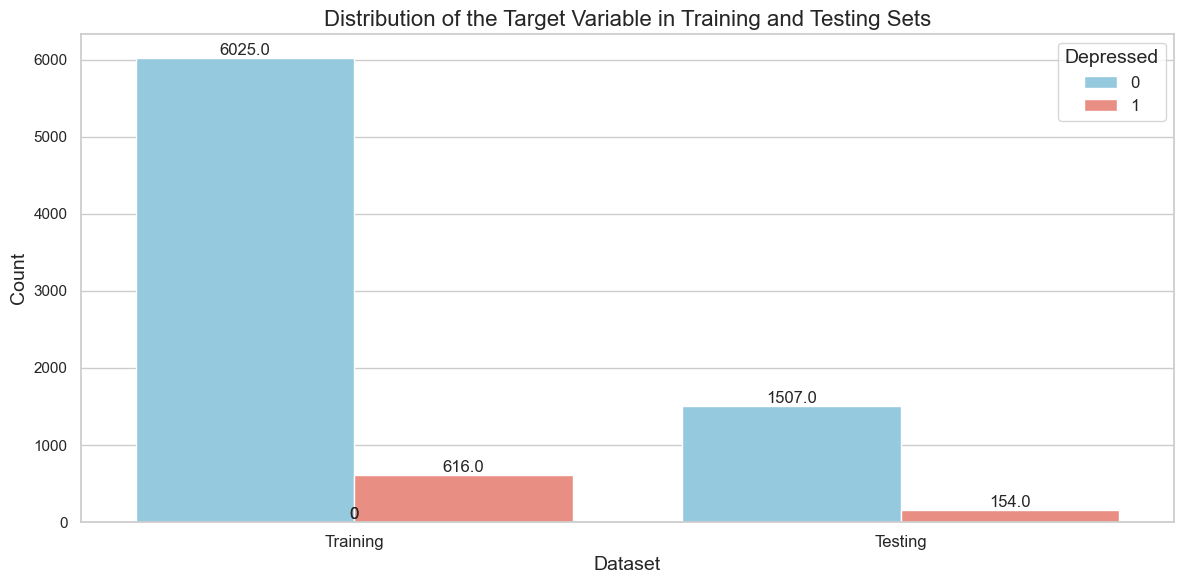

In [143]:
# Assuming merged_df is already defined
# Prepare the data
X = merged_df.drop(['Depressed', 'PHQ9_total', 'SEQN'], axis=1)  # Features (all columns except the target)
y = merged_df['Depressed']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create a DataFrame for plotting
train_df = pd.DataFrame({'Set': 'Training', 'Depressed': y_train})
test_df = pd.DataFrame({'Set': 'Testing', 'Depressed': y_test})
combined_df = pd.concat([train_df, test_df])

# Set up the plot style
sns.set(style="whitegrid")

# Plot the distribution of the target variable in training and test sets
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=combined_df, x='Set', hue='Depressed', palette=['skyblue', 'salmon'])

# Add annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=12)

# Customize the plot
plt.title('Distribution of the Target Variable in Training and Testing Sets', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Depressed', fontsize=12, title_fontsize=14)

# Save the plot as an image file
plt.tight_layout()
plt.savefig('target_distribution_plot.png')
plt.show()


## IMPUTATION

### MODE IMPUTATION FOR MISSING VALUES

In [145]:
# Function to apply mode imputation
def impute_mode(data):
    imputer = SimpleImputer(strategy='most_frequent')
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Apply the imputation to the training and testing data
X_train_imputed = impute_mode(X_train.copy())
X_test_imputed = impute_mode(X_test.copy())

# Output to check
print("Imputed Training Data:")
print(X_train_imputed.head())
print("Imputed Testing Data:")
print(X_test_imputed.head())

Imputed Training Data:
   ALQ111  ALQ121  ALQ142  ALQ151  DBQ700  DBQ197  DBQ229  DBQ235A  DBQ235B  \
0     1.0     0.0     0.0     2.0     5.0     0.0     2.0      3.0      3.0   
1     1.0     0.0     0.0     2.0     4.0     2.0     3.0      3.0      3.0   
2     1.0     4.0     0.0     2.0     2.0     3.0     3.0      3.0      3.0   
3     1.0     0.0     0.0     2.0     3.0     3.0     3.0      3.0      1.0   
4     1.0     4.0     4.0     1.0     3.0     0.0     3.0      2.0      1.0   

   DBQ235C  ...  WHD020  WHQ030  WHQ040  WHD050  WHQ070  WHQ225  WHD110  \
0      2.0  ...   232.0     1.0     2.0   232.0     1.0     1.0   195.0   
1      2.0  ...   160.0     1.0     2.0   175.0     2.0     1.0   135.0   
2      3.0  ...   190.0     3.0     3.0   185.0     2.0     5.0   170.0   
3      1.0  ...   185.0     3.0     3.0   175.0     2.0     1.0   140.0   
4      1.0  ...   220.0     1.0     2.0   260.0     2.0     2.0   150.0   

   WHD120  WHD140  WHQ150  
0   175.0   275.0    55

In [146]:
# Check for NaN values in X_train_imputed
has_nan_train = np.isnan(X_train_imputed).any()
print(f"X_train_imputed has NaN values: {has_nan_train}")

# Check for NaN values in X_test_imputed
has_nan_test = np.isnan(X_test_imputed).any()
print(f"X_test_imputed has NaN values: {has_nan_test}")


X_train_imputed has NaN values: ALQ111    False
ALQ121    False
ALQ142    False
ALQ151    False
DBQ700    False
          ...  
WHQ225    False
WHD110    False
WHD120    False
WHD140    False
WHQ150    False
Length: 66, dtype: bool
X_test_imputed has NaN values: ALQ111    False
ALQ121    False
ALQ142    False
ALQ151    False
DBQ700    False
          ...  
WHQ225    False
WHD110    False
WHD120    False
WHD140    False
WHQ150    False
Length: 66, dtype: bool


## MODEL DEPLOYMENT

### 1. LOGISTIC REGRESSION

In [147]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 0.5, 1, 5],
    'penalty': ['l2'],  # 'none' is not valid with 'lbfgs' and 'liblinear'
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [300, 500] 
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_imputed, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Use the best estimator to make predictions
best_log_reg = grid_search.best_estimator_

# Fit the best model on the training data
best_log_reg.fit(X_train_imputed, y_train)

# Save the best model
joblib.dump(grid_search.best_estimator_, 'best_log_reg_model.pkl')

# Predict on the training data and test data
train_predictions = best_log_reg.predict(X_train_imputed)
test_predictions = best_log_reg.predict(X_test_imputed)

# Evaluate the model
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Detailed classification report
print(classification_report(y_test, test_predictions, zero_division=0))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_log_reg.predict_proba(X_test_imputed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters: {'C': 0.1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.909501663539032
Training Accuracy: 0.910254479747026
Test Accuracy: 0.9060806742925949
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1507
           1       0.48      0.13      0.20       154

    accuracy                           0.91      1661
   macro avg       0.70      0.56      0.58      1661
weighted avg       0.88      0.91      0.88      1661

ROC-AUC Score: 0.7995242978653728


c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### LOGISTIC REGRESSION PLOTS

#### LOGISTIC REGRESSION FEATURE IMPORTANCE

ROC-AUC Score: 0.7995242978653728


<Figure size 1000x700 with 0 Axes>

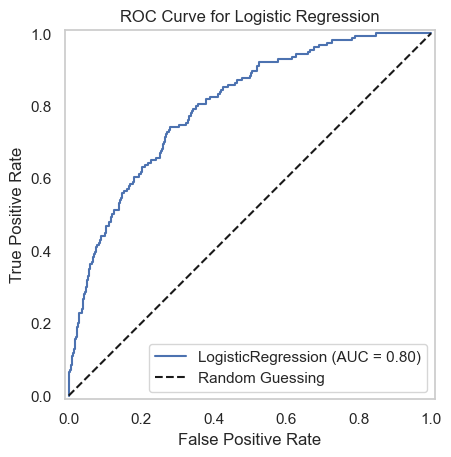

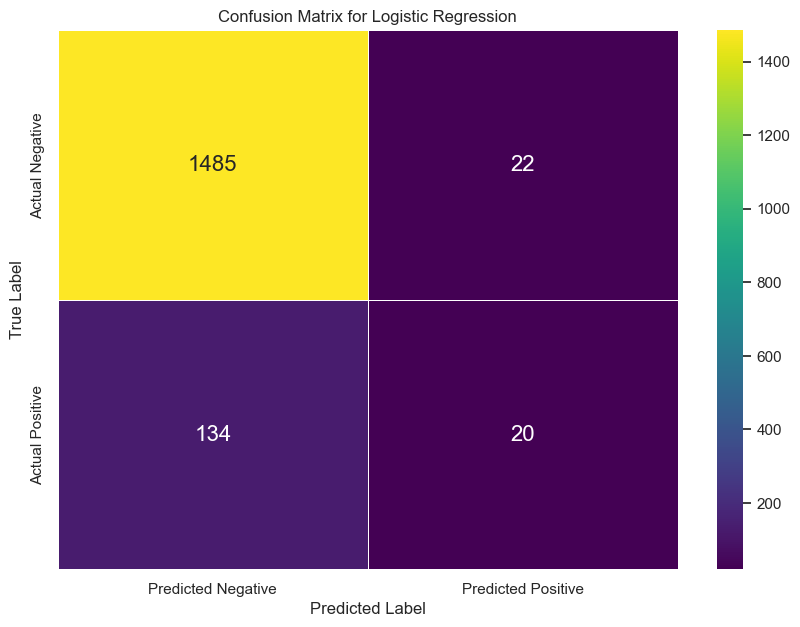

C:\Users\giann\AppData\Local\Temp\ipykernel_11624\1829823577.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")


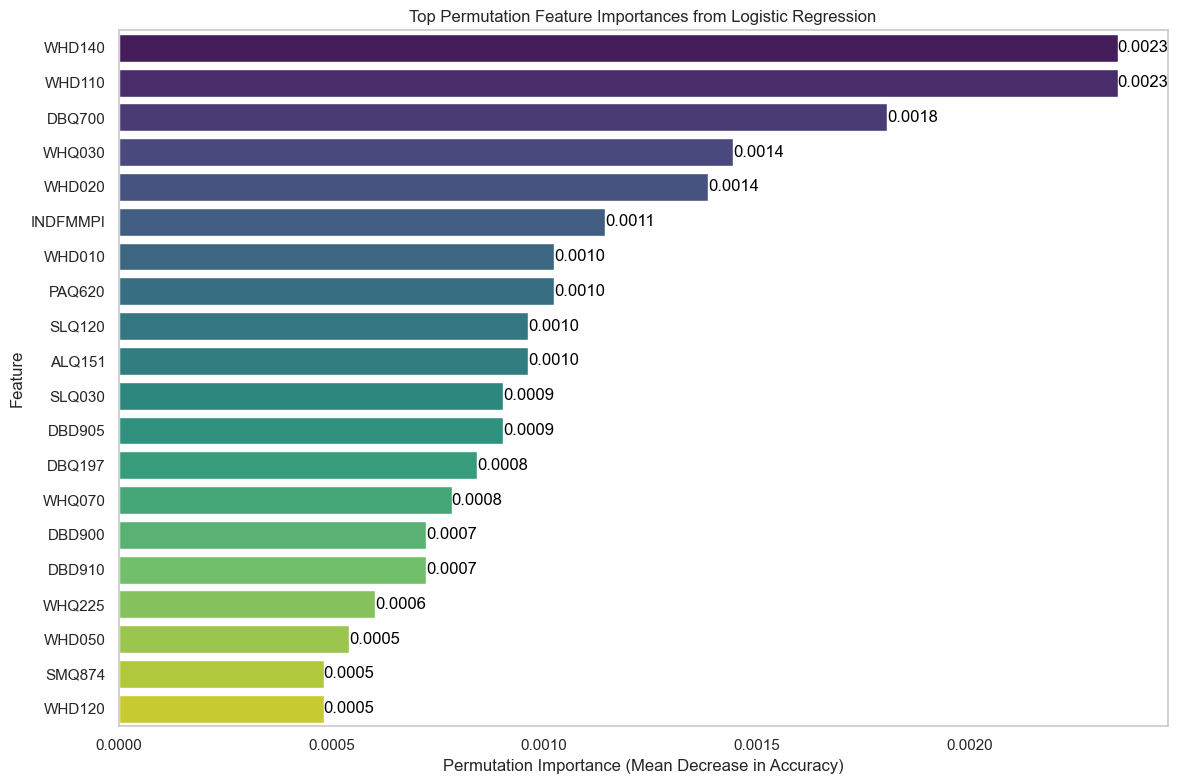

In [148]:
# Function to apply mode imputation
def impute_mode(data):
    imputer = SimpleImputer(strategy='most_frequent')
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Apply the imputation to the training and testing data
X_train_imputed = impute_mode(X_train.copy())
X_test_imputed = impute_mode(X_test.copy())

# Assuming best_log_reg is already trained and test_predictions are available
# If X_train_imputed is a DataFrame, get the column names
if hasattr(X_train_imputed, 'columns'):
    feature_names = X_train_imputed.columns.tolist()
else:
    # If X_train_imputed is not a DataFrame, create placeholder names
    feature_names = [f"Feature {i}" for i in range(X_train_imputed.shape[1])]

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_log_reg.predict_proba(X_test_imputed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
RocCurveDisplay.from_estimator(best_log_reg, X_test_imputed, y_test)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plotting the confusion matrix with the viridis colormap
cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Perform permutation importance on test data
results = permutation_importance(best_log_reg, X_test_imputed, y_test, scoring='accuracy', n_repeats=10, n_jobs=-1, random_state=42)

# Get the importance scores and sort them
importance_scores = results.importances_mean
sorted_indices = np.argsort(importance_scores)[::-1]

# Ensure the number of top features does not exceed the number of available features
top_n = min(20, len(feature_names))

# Select top N features
top_indices = sorted_indices[:top_n]
top_importances = importance_scores[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Plot the top N permutation feature importances with feature names
plt.figure(figsize=(12, 8))
sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")
plt.xlabel('Permutation Importance (Mean Decrease in Accuracy)')
plt.ylabel('Feature')
plt.title('Top Permutation Feature Importances from Logistic Regression')
plt.grid(axis='x')
for i, v in enumerate(top_importances):
    plt.text(v, i, f'{v:.4f}', color='black', va='center')
plt.tight_layout()
plt.show()



### B. OVERSAMPLED

c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Best Parameters: {'log_reg__C': 1, 'log_reg__max_iter': 300, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}
Best Cross-Validation Score: 0.7947717842323652
Test Accuracy: 0.7585791691751956
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1507
           1       0.23      0.68      0.34       154

    accuracy                           0.76      1661
   macro avg       0.59      0.72      0.60      1661
weighted avg       0.89      0.76      0.80      1661

ROC-AUC Score: 0.8059143908513516


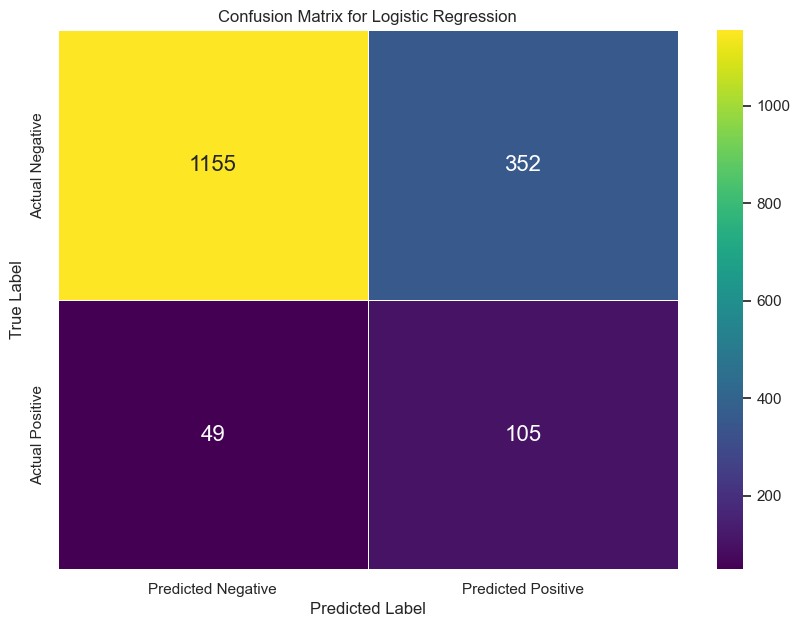

<Figure size 1000x700 with 0 Axes>

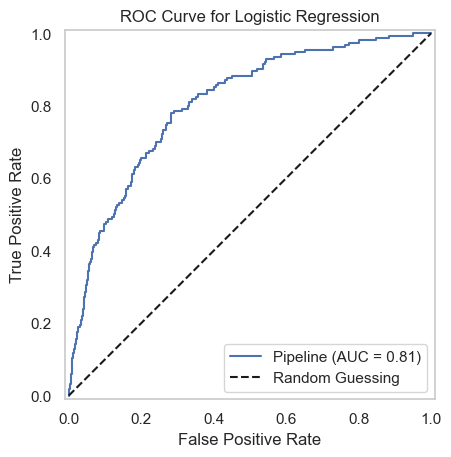

C:\Users\giann\AppData\Local\Temp\ipykernel_11624\3153126250.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")


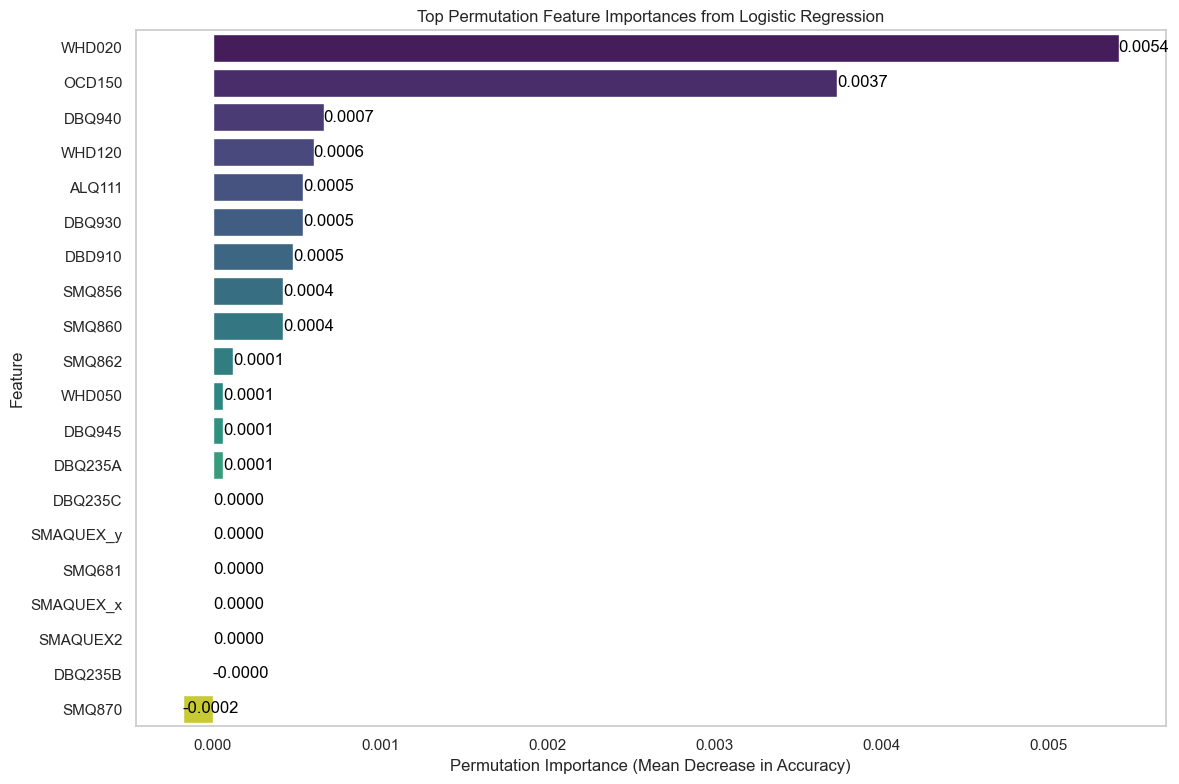

In [149]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Define the parameter grid
param_grid = {
    'log_reg__C': [0.1, 0.5, 1, 5],
    'log_reg__penalty': ['l2'],
    'log_reg__solver': ['lbfgs', 'liblinear'],
    'log_reg__max_iter': [300, 500]
}

# Create a pipeline with imputation and Logistic Regression
pipeline = Pipeline([
    ('log_reg', LogisticRegression())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Use the best estimator to make predictions
best_log_reg = grid_search.best_estimator_

# Save the best model
joblib.dump(best_log_reg, 'best_log_reg_model_oversampled.pkl')

# Predict on the test data
test_predictions = best_log_reg.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, test_predictions, zero_division=0))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_log_reg.predict_proba(X_test_imputed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Plotting the confusion matrix with improved color scheme
cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
RocCurveDisplay.from_estimator(best_log_reg, X_test_imputed, y_test)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Perform permutation importance on test data
results = permutation_importance(best_log_reg, X_test_imputed, y_test, scoring='accuracy', n_repeats=10, n_jobs=-1, random_state=42)

importance_scores = results.importances_mean
sorted_indices = np.argsort(importance_scores)[::-1]

if hasattr(X_train_imputed, 'columns'):
    feature_names = X_train_imputed.columns.tolist()
else:
    feature_names = [f"Feature {i}" for i in range(X_train_imputed.shape[1])]

top_n = min(20, len(feature_names))
top_indices = sorted_indices[:top_n]
top_importances = importance_scores[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Improved permutation importance plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")
plt.xlabel('Permutation Importance (Mean Decrease in Accuracy)')
plt.ylabel('Feature')
plt.title('Top Permutation Feature Importances from Logistic Regression')
plt.grid(axis='x')
for i, v in enumerate(top_importances):
    plt.text(v, i, f'{v:.4f}', color='black', va='center')
plt.tight_layout()
plt.show()


#### Plotting the class distribution before and after SMOTE

C:\Users\giann\AppData\Local\Temp\ipykernel_11624\290661970.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_mapped, ax=ax[0], palette=palette)
C:\Users\giann\AppData\Local\Temp\ipykernel_11624\290661970.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res_mapped, ax=ax[1], palette=palette)


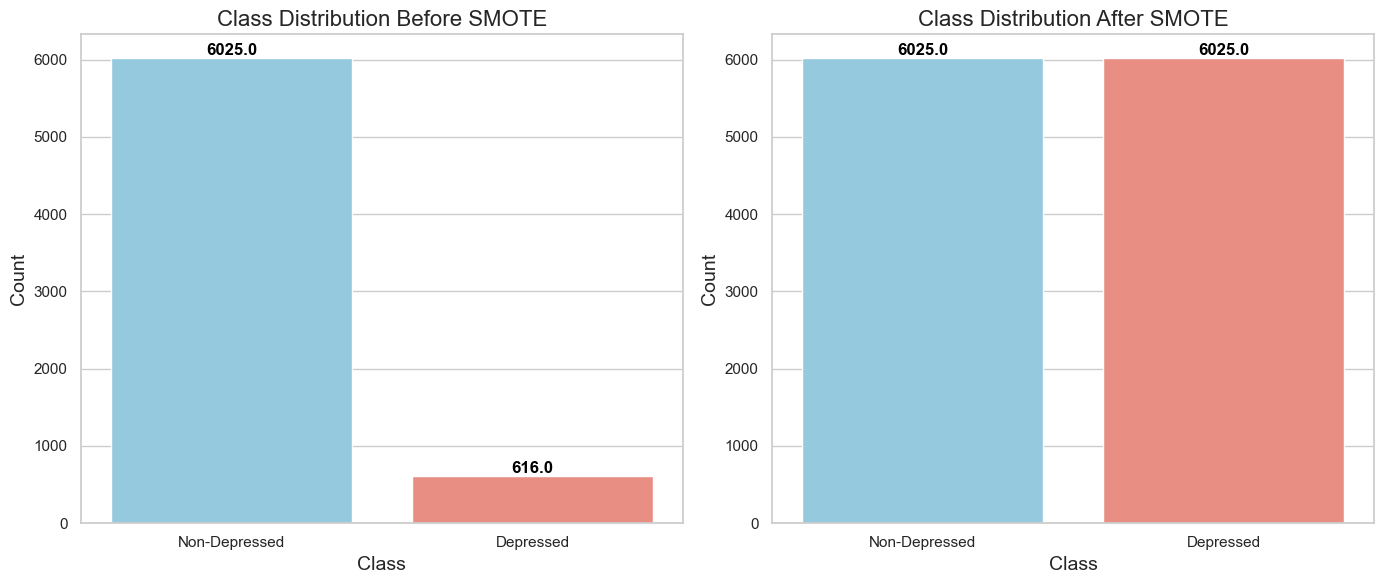

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns


# Mapping the class labels to their corresponding names
label_mapping = {0: "Non-Depressed", 1: "Depressed"}
y_train_mapped = y_train.map(label_mapping)
y_res_mapped = y_train_resampled.map(label_mapping)

# Define the custom color palette
palette = {'Non-Depressed': "skyblue", 'Depressed': "salmon"}

# Plotting the class distribution before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Before SMOTE
sns.countplot(x=y_train_mapped, ax=ax[0], palette=palette)
ax[0].set_title('Class Distribution Before SMOTE', fontsize=16)
ax[0].set_xlabel('Class', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x() + p.get_width() / 2., height + 1, height, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# After SMOTE
sns.countplot(x=y_res_mapped, ax=ax[1], palette=palette)
ax[1].set_title('Class Distribution After SMOTE', fontsize=16)
ax[1].set_xlabel('Class', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)
for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x() + p.get_width() / 2., height + 1, height, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Adjust layout and save the plot as an image file
plt.tight_layout()
plt.savefig('class_distribution_before_and_after_smote.png')
plt.show()


### 2. RANDOM FOREST

In [28]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 130],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_imputed, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")


# Save the best model
joblib.dump(grid_search.best_estimator_, 'best_rf_model.pkl')


# Use the best estimator to make predictions
best_random_forest = grid_search.best_estimator_

# Fit the best model on the training data
best_random_forest.fit(X_train_imputed, y_train)

# Predict on the test data
rf_test_predictions = best_random_forest.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_test_predictions)
print(f"Test Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, rf_test_predictions))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_random_forest.predict_proba(X_test_imputed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_test_predictions))

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-Validation Score: 0.9093512877695884
Test Accuracy: 0.9084888621312462
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1507
           1       0.57      0.05      0.10       154

    accuracy                           0.91      1661
   macro avg       0.74      0.52      0.52      1661
weighted avg       0.88      0.91      0.87      1661

ROC-AUC Score: 0.8040292487870457
Confusion Matrix:
[[1501    6]
 [ 146    8]]


#### RANDOM FOREST PLOTS

#### RANDOM FOREST FEATURE IMPORTANCE

<Figure size 1000x700 with 0 Axes>

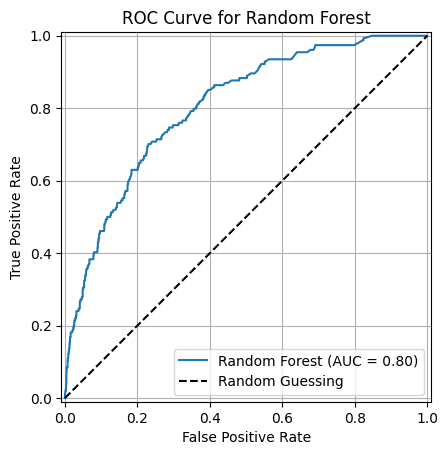

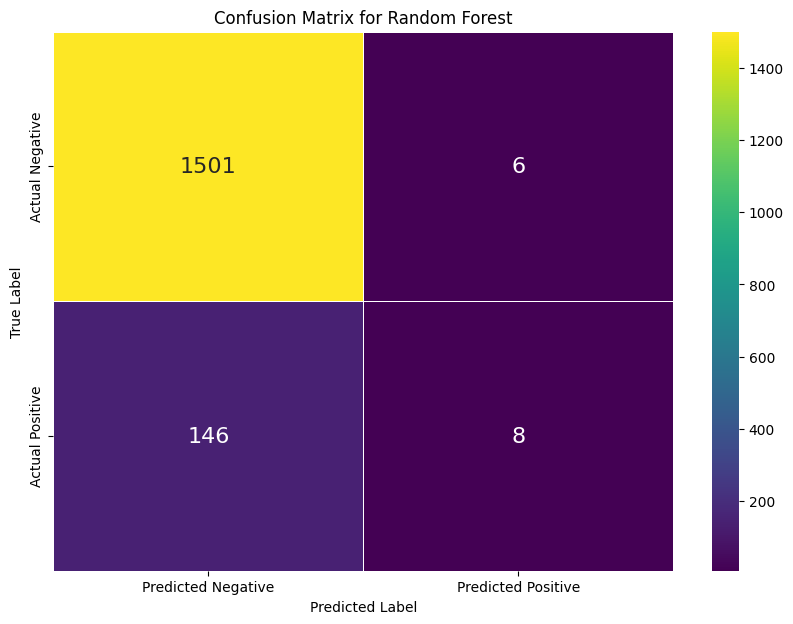

C:\Users\giann\AppData\Local\Temp\ipykernel_14588\1866570811.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")


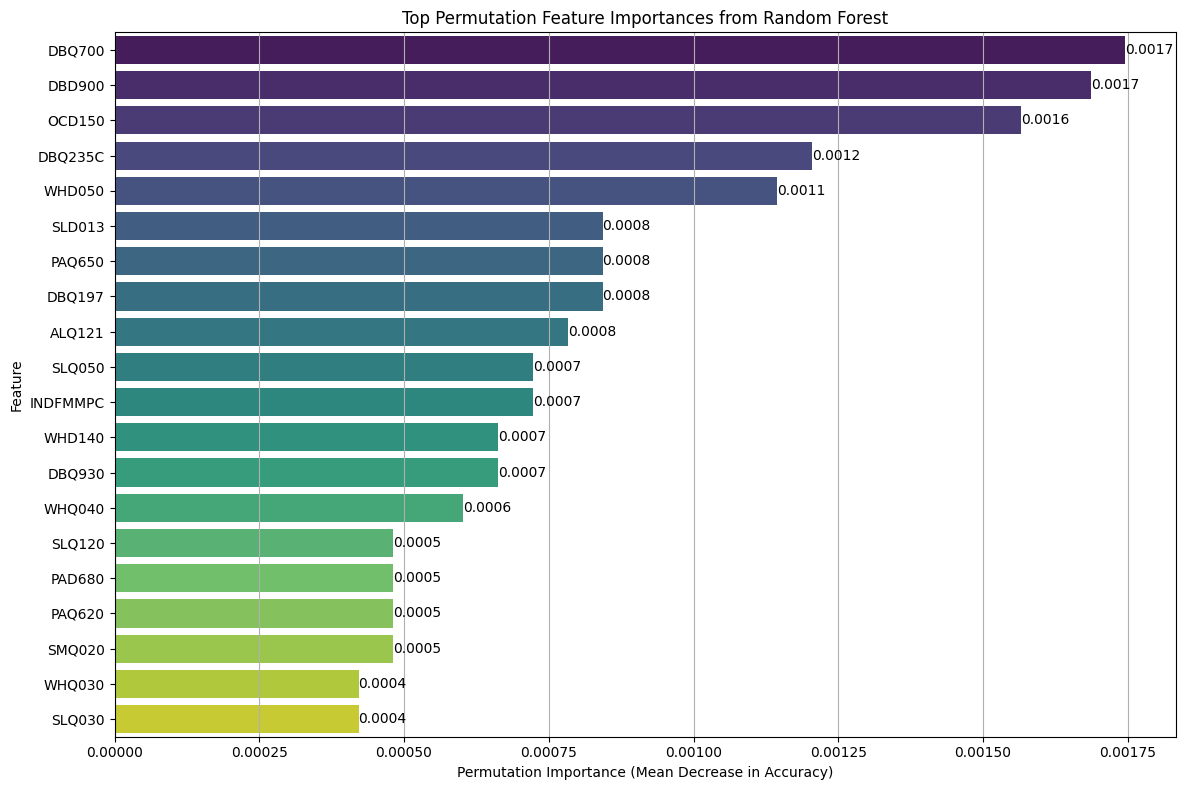

In [29]:
# Assuming best_random_forest, rf_test_predictions, and X_test_imputed are already defined
# Compute ROC curve and ROC area
roc_auc = roc_auc_score(y_test, best_random_forest.predict_proba(X_test_imputed)[:, 1])
fpr, tpr, _ = roc_curve(y_test, best_random_forest.predict_proba(X_test_imputed)[:, 1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')

# Plot ROC curve
plt.figure(figsize=(10, 7))
roc_display.plot()
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plotting the confusion matrix with improved color scheme
cm = confusion_matrix(y_test, rf_test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Perform permutation importance on test data
results = permutation_importance(best_random_forest, X_test_imputed, y_test, scoring='accuracy', n_repeats=10, n_jobs=-1, random_state=42)

# Get the importance scores and sort them
importance_scores = results.importances_mean
sorted_indices = np.argsort(importance_scores)[::-1]

# Get feature names (assuming you have them in a list called feature_names)
# If you don't have feature names, you can use placeholder names
if hasattr(X_train_imputed, 'columns'):
    feature_names = X_train_imputed.columns.tolist()
else:
    feature_names = [f"Feature {i}" for i in range(X_train_imputed.shape[1])]

# Ensure the number of top features does not exceed the number of available features
top_n = min(20, len(feature_names))

# Select top N features
top_indices = sorted_indices[:top_n]
top_importances = importance_scores[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Improved permutation importance plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")
plt.xlabel('Permutation Importance (Mean Decrease in Accuracy)')
plt.ylabel('Feature')
plt.title('Top Permutation Feature Importances from Random Forest')
plt.grid(axis='x')
for i, v in enumerate(top_importances):
    plt.text(v, i, f'{v:.4f}', color='black', va='center')
plt.tight_layout()
plt.show()



### B. OVERSAMPLED

Best Parameters: {'rf__bootstrap': False, 'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 130}
Best Cross-Validation Score: 0.9465560165975104
Test Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1507
           1       0.57      0.08      0.15       154

    accuracy                           0.91      1661
   macro avg       0.74      0.54      0.55      1661
weighted avg       0.88      0.91      0.88      1661

ROC-AUC Score: 0.8053132998388474


<Figure size 1000x700 with 0 Axes>

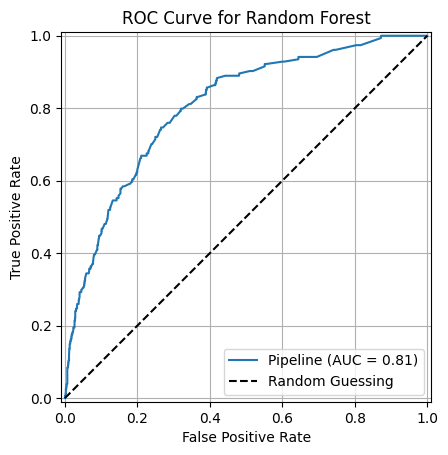

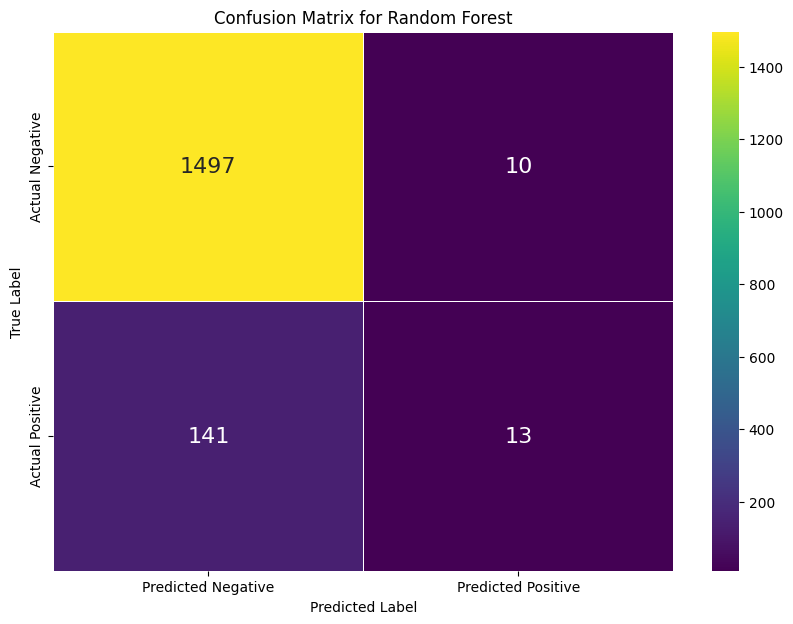

C:\Users\giann\AppData\Local\Temp\ipykernel_14588\940780016.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")


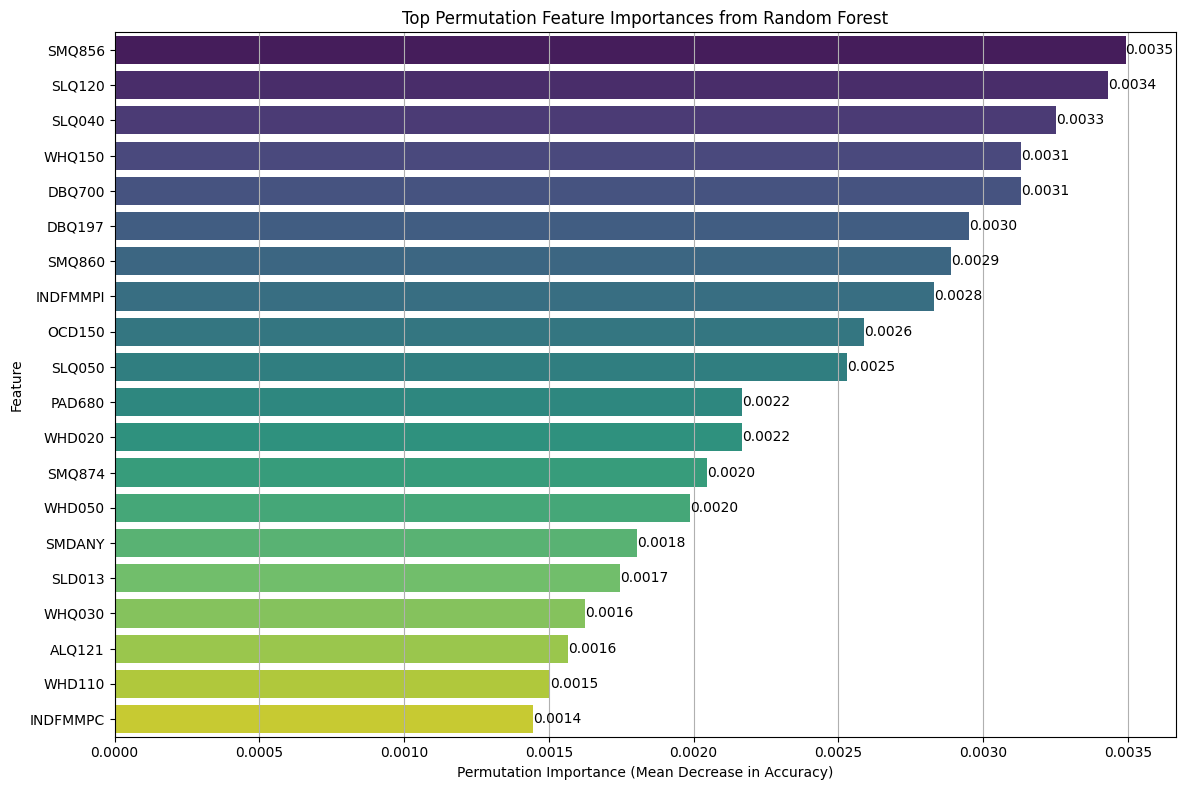

In [30]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [50, 130],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

# Create a pipeline with imputation and Random Forest
pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Use the best estimator to make predictions
best_random_forest = grid_search.best_estimator_

# Save the best model
joblib.dump(best_random_forest, 'best_rf_model_oversampled.pkl')

# Predict on the test data
rf_test_predictions = best_random_forest.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_test_predictions)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, rf_test_predictions, zero_division=0))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_random_forest.predict_proba(X_test_imputed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
RocCurveDisplay.from_estimator(best_random_forest, X_test_imputed, y_test)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plotting the confusion matrix with improved color scheme
cm = confusion_matrix(y_test, rf_test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Perform permutation importance on test data
results = permutation_importance(best_random_forest, X_test_imputed, y_test, scoring='accuracy', n_repeats=10, n_jobs=-1, random_state=42)

importance_scores = results.importances_mean
sorted_indices = np.argsort(importance_scores)[::-1]

if hasattr(X_train_imputed, 'columns'):
    feature_names = X_train_imputed.columns.tolist()
else:
    feature_names = [f"Feature {i}" for i in range(X_train_imputed.shape[1])]

top_n = min(20, len(feature_names))
top_indices = sorted_indices[:top_n]
top_importances = importance_scores[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Improved permutation importance plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")
plt.xlabel('Permutation Importance (Mean Decrease in Accuracy)')
plt.ylabel('Feature')
plt.title('Top Permutation Feature Importances from Random Forest')
plt.grid(axis='x')
for i, v in enumerate(top_importances):
    plt.text(v, i, f'{v:.4f}', color='black', va='center')
plt.tight_layout()
plt.show()


### 3. SVM

Best Parameters: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best Cross-Validation Score: 0.9072429673547463
Test Accuracy: 0.9072847682119205
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1507
           1       0.00      0.00      0.00       154

    accuracy                           0.91      1661
   macro avg       0.45      0.50      0.48      1661
weighted avg       0.82      0.91      0.86      1661



c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC Score: 0.7638207843914546


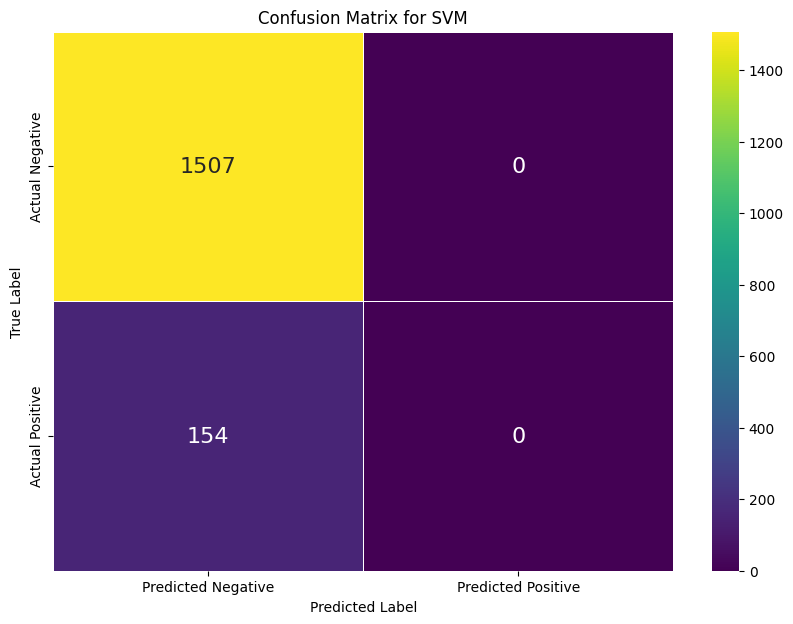

<Figure size 1000x700 with 0 Axes>

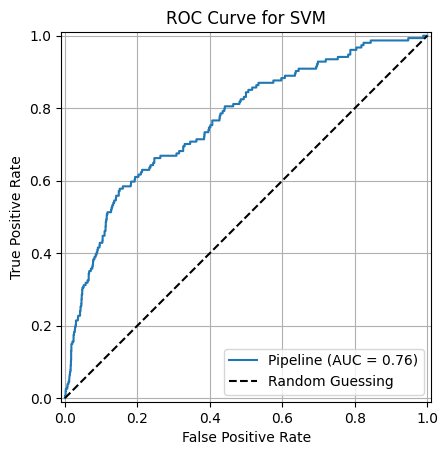

In [31]:
# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 5],
    'svm__gamma': ['scale', 0.1],
    'svm__kernel': ['rbf']
}

# Create a pipeline with scaling and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_imputed, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Use the best estimator to make predictions
best_svm_model = grid_search.best_estimator_

# Save the best model
joblib.dump(best_svm_model, 'best_svm_model.pkl')

# Predict on the test data
svm_predictions = best_svm_model.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, svm_predictions)
print(f"Test Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, svm_predictions))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_svm_model.predict_proba(X_test_imputed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Plotting the confusion matrix with improved color scheme
cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
RocCurveDisplay.from_estimator(best_svm_model, X_test_imputed, y_test)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()



### B. OVERSAMPLED

Best Parameters: {'svm__C': 5, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best Cross-Validation Score: 0.9894605809128632
Test Accuracy: 0.9072847682119205
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1507
           1       0.00      0.00      0.00       154

    accuracy                           0.91      1661
   macro avg       0.45      0.50      0.48      1661
weighted avg       0.82      0.91      0.86      1661

ROC-AUC Score: 0.7292505106041934


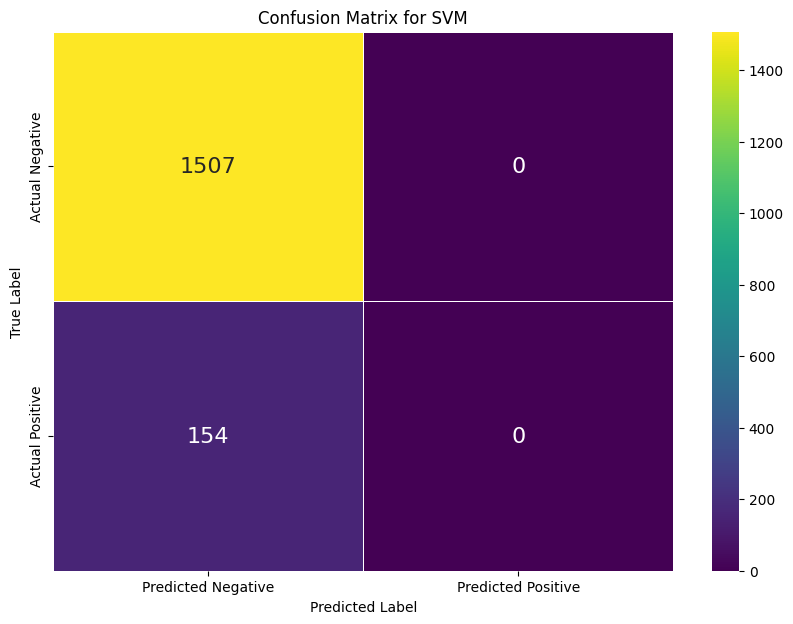

<Figure size 1000x700 with 0 Axes>

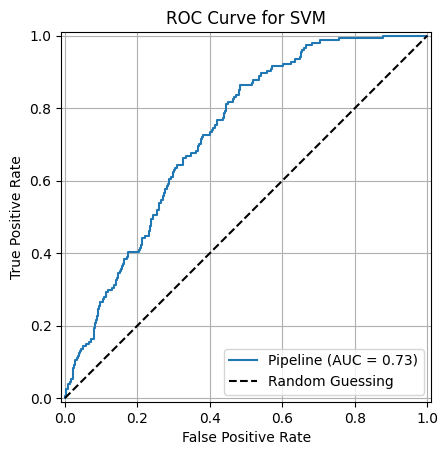

In [32]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 5],
    'svm__gamma': ['scale', 0.1],
    'svm__kernel': ['rbf']
}

# Create a pipeline with scaling and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_

# Save the best model
joblib.dump(best_svm, 'best_svm_model_oversampled.pkl')

# Predict on the test data
svm_predictions = best_svm.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, svm_predictions)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, svm_predictions, zero_division=0))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, best_svm.predict_proba(X_test_imputed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Plotting the confusion matrix with improved color scheme
cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
RocCurveDisplay.from_estimator(best_svm, X_test_imputed, y_test)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()




## 4. MLP

In [33]:
def create_model(input_dim, layers=[256, 128], dropout_rate=0.2, learning_rate=0.001, loss='binary_crossentropy', activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, kernel_regularizer=l1(0.01)))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for layer_size in layers[1:]:
        model.add(Dense(layer_size))
        if activation == 'leaky_relu':
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
        
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

# Define the input dimension
input_dim = X_train_imputed.shape[1]

# Wrap the model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_model, input_dim=input_dim, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [32],
    'epochs': [400],
    'layers': [
        [64, 32],
        [128, 64, 32],
    ],
    'dropout_rate': [0.1],
    'learning_rate': [0.001, 0.1],
    'loss': ['binary_crossentropy'],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['nadam']
}

# Define the stratified K-fold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train_imputed, y_train)

# Save the best model using TensorFlow's save_model function
best_model = grid_result.best_estimator_.model
save_model(best_model, 'best_nn_model.h5')

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


C:\Users\giann\AppData\Local\Temp\ipykernel_14588\4009098024.py:38: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, input_dim=input_dim, verbose=0)
c:\Users\giann\Anaconda3\envs\tf_env\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.907243 using {'activation': 'sigmoid', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [64, 32], 'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.906339 (0.001555) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [64, 32], 'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.907092 (0.000223) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [64, 32], 'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.905134 (0.003236) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [128, 64, 32], 'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.899712 (0.007642) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [128, 64, 32], 'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'optimizer': 'nada

52/52 [==============================] - 0s 3ms/step
Test Accuracy: 0.9072847682119205
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1507
           1       0.00      0.00      0.00       154

    accuracy                           0.91      1661
   macro avg       0.45      0.50      0.48      1661
weighted avg       0.82      0.91      0.86      1661

ROC-AUC Score: 0.5422271822404536


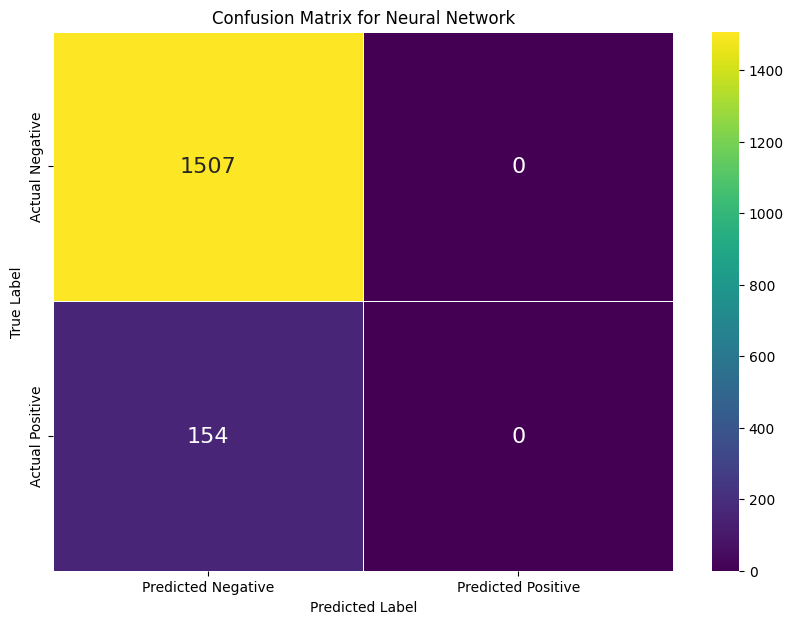

<Figure size 1000x700 with 0 Axes>

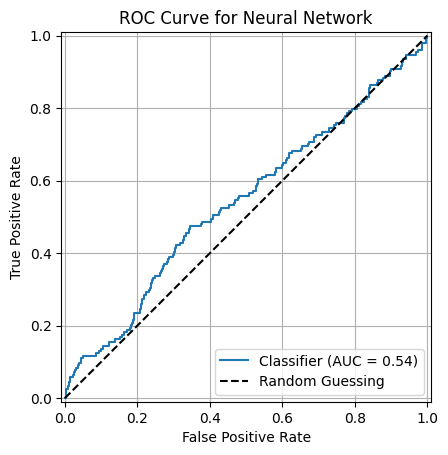

In [34]:
# Load the best model using TensorFlow's load_model function
best_nn_model = load_model('best_nn_model.h5')

# Predict on the test data
nn_predictions_proba = best_nn_model.predict(X_test_imputed)
nn_predictions = (nn_predictions_proba > 0.5).astype(int).flatten()

# Evaluate the model
accuracy = accuracy_score(y_test, nn_predictions)
print(f"Test Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, nn_predictions, zero_division=0))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, nn_predictions_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Plotting the confusion matrix with improved color scheme
cm = confusion_matrix(y_test, nn_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
RocCurveDisplay.from_predictions(y_test, nn_predictions_proba)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()




### B. OVERSAMPLED

In [35]:
def create_model(input_dim, layers=[256, 128], dropout_rate=0.2, learning_rate=0.001, loss='binary_crossentropy', activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, kernel_regularizer=l1(0.01)))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for layer_size in layers[1:]:
        model.add(Dense(layer_size))
        if activation == 'leaky_relu':
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
        
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Define the input dimension
input_dim = X_train_resampled.shape[1]

# Wrap the model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_model, input_dim=input_dim, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [32],
    'epochs': [400],
    'layers': [
        [64, 32],
        [128, 64, 32],
    ],
    'dropout_rate': [0.1],
    'learning_rate': [0.001, 0.1],
    'loss': ['binary_crossentropy'],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['nadam']
}

# Define the stratified K-fold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train_resampled, y_train_resampled)

# Save the best model
best_model = grid_result.best_estimator_.model
save_model(best_model, 'best_nn_model_oversampled.h5')

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



C:\Users\giann\AppData\Local\Temp\ipykernel_14588\3618773829.py:42: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, input_dim=input_dim, verbose=0)


Best: 0.677518 using {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [128, 64, 32], 'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.632274 (0.081662) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [64, 32], 'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.516513 (0.022762) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [64, 32], 'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.677518 (0.121921) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [128, 64, 32], 'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'nadam'}
0.524649 (0.018486) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 400, 'layers': [128, 64, 32], 'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'optimizer': 'na

52/52 [==============================] - 0s 3ms/step
Test Accuracy: 0.09572546658639373
              precision    recall  f1-score   support

           0       0.86      0.00      0.01      1507
           1       0.09      0.99      0.17       154

    accuracy                           0.10      1661
   macro avg       0.47      0.50      0.09      1661
weighted avg       0.79      0.10      0.02      1661

ROC-AUC Score: 0.5368022819913995


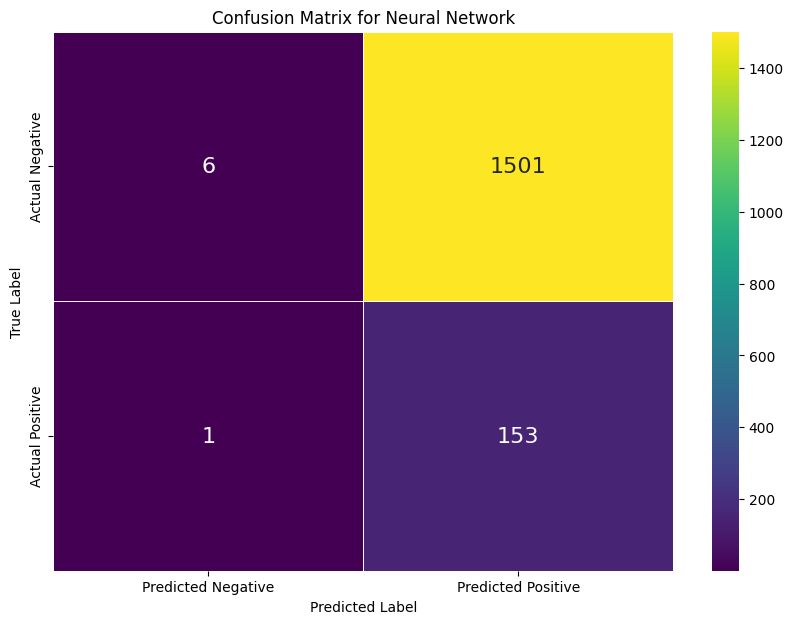

<Figure size 1000x700 with 0 Axes>

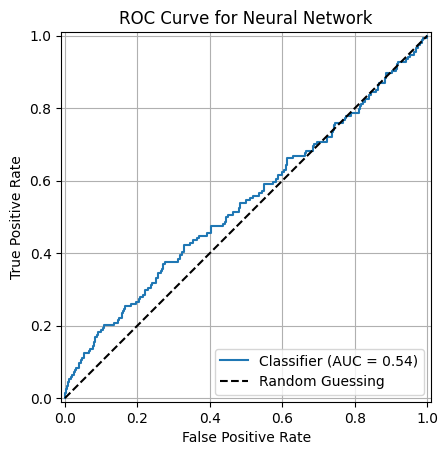

In [36]:
# Load the best model
best_nn_model = load_model('best_nn_model_oversampled.h5')

# Predict on the test data
nn_predictions_proba = best_nn_model.predict(X_test_imputed)
nn_predictions = (nn_predictions_proba > 0.5).astype(int).flatten()

# Evaluate the model
accuracy = accuracy_score(y_test, nn_predictions)
print(f"Test Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, nn_predictions, zero_division=0))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, nn_predictions_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Plotting the confusion matrix with improved color scheme
cm = confusion_matrix(y_test, nn_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidths=.5, annot_kws={"size": 16})
plt.title("Confusion Matrix for Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
RocCurveDisplay.from_predictions(y_test, nn_predictions_proba)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title("ROC Curve for Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()
